# Classifying Fashion-MNIST

Now it's your turn to build and train a neural network. You'll be using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), a drop-in replacement for the MNIST dataset. MNIST is actually quite trivial with neural networks where you can easily achieve better than 97% accuracy. Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST, so it's a better representation of the actual performance of your network, and a better representation of datasets you'll use in the real world.

<img src='../../../images/AI_Programming_with_Python_ND_P2_L_10.png' width=500px>

In this notebook, you'll build your own neural network. For the most part, you could just copy and paste the code from Part 3, but you wouldn't be learning. It's important for you to write the code yourself and get it to work. Feel free to consult the previous notebooks though as you work through this.

First off, let's load the dataset through torchvision.

In [1]:
import torch
from torchvision import datasets, transforms
import helper

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Here we can see one of the images.

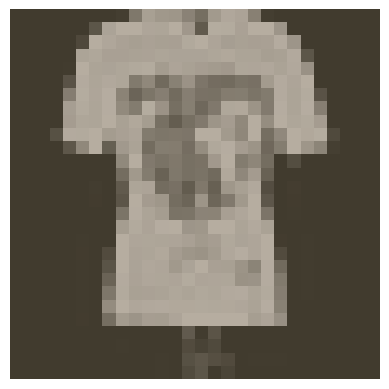

In [2]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

## Building the network

Here you should define your network. As with MNIST, each image is 28x28 which is a total of 784 pixels, and there are 10 classes. You should include at least one hidden layer. We suggest you use ReLU activations for the layers and to return the logits or log-softmax from the forward pass. It's up to you how many layers you add and the size of those layers.

In [4]:
from torch import nn, optim
import torch.nn.functional as F

"""
Apply log-softmax activation along the class dimension for multi-class classification.

The log_softmax function converts raw logits to log-probabilities by applying
softmax followed by logarithm. The dim=1 parameter specifies to apply this
operation along dimension 1 (the class dimension).

Tensor Shape Context:
    Input tensor shape: (batch_size, num_classes)
    - Dimension 0: Batch dimension (e.g., 64 samples)  
    - Dimension 1: Class dimension (10 classes for Fashion-MNIST)

Args:
    self.fc4(x): Raw logits tensor with shape (batch_size, 10)
    dim=1: Apply softmax along dimension 1 (across the 10 classes)

Returns:
    torch.Tensor: Log-probabilities with shape (batch_size, 10) where each
    row sums to 1.0 when exponentiated, representing class probabilities
    for each sample.

Why dim=1?:
    - dim=0 would normalize across the batch (wrong - compares different samples)
    - dim=1 normalizes across classes (correct - converts logits to probabilities)
    
    For each sample, we want: sum(exp(log_probs)) = 1.0 across all 10 classes

Example:
    >>> logits = torch.tensor([[2.1, -0.5, 1.8], [0.3, 1.2, -0.8]])  # 2 samples, 3 classes
    >>> log_probs = F.log_softmax(logits, dim=1)
    >>> # Each row now represents log-probabilities for that sample's classes
    
Mathematical Operation:
    log_softmax(x_i) = log(exp(x_i) / sum(exp(x_j))) = x_i - log(sum(exp(x_j)))
    Applied along dim=1 ensures proper probability distribution per sample.

Note:
    Used with NLLLoss (Negative Log-Likelihood Loss) which expects log-probabilities
    as input for efficient and numerically stable training.
"""

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

# Train the network

Now you should create your network and train it. First you'll want to define [the criterion](http://pytorch.org/docs/master/nn.html#loss-functions) (something like `nn.CrossEntropyLoss` or `nn.NLLLoss`) and [the optimizer](http://pytorch.org/docs/master/optim.html) (typically `optim.SGD` or `optim.Adam`).

Then write the training code. Remember the training pass is a fairly straightforward process:

* Make a forward pass through the network to get the logits 
* Use the logits to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

By adjusting the hyperparameters (hidden units, learning rate, etc), you should be able to get the training loss below 0.4.

In [5]:
# Create the network, define the criterion and optimizer
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [6]:
# TODO: Train the network here
epochs = 5

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss for iteration #{e+1} -> {running_loss/len(trainloader)}")

Training loss for iteration #1 -> 0.5124026707558236
Training loss for iteration #2 -> 0.39043854856128885
Training loss for iteration #3 -> 0.3509939063602546
Training loss for iteration #4 -> 0.3365630246460565
Training loss for iteration #5 -> 0.3157831350845823


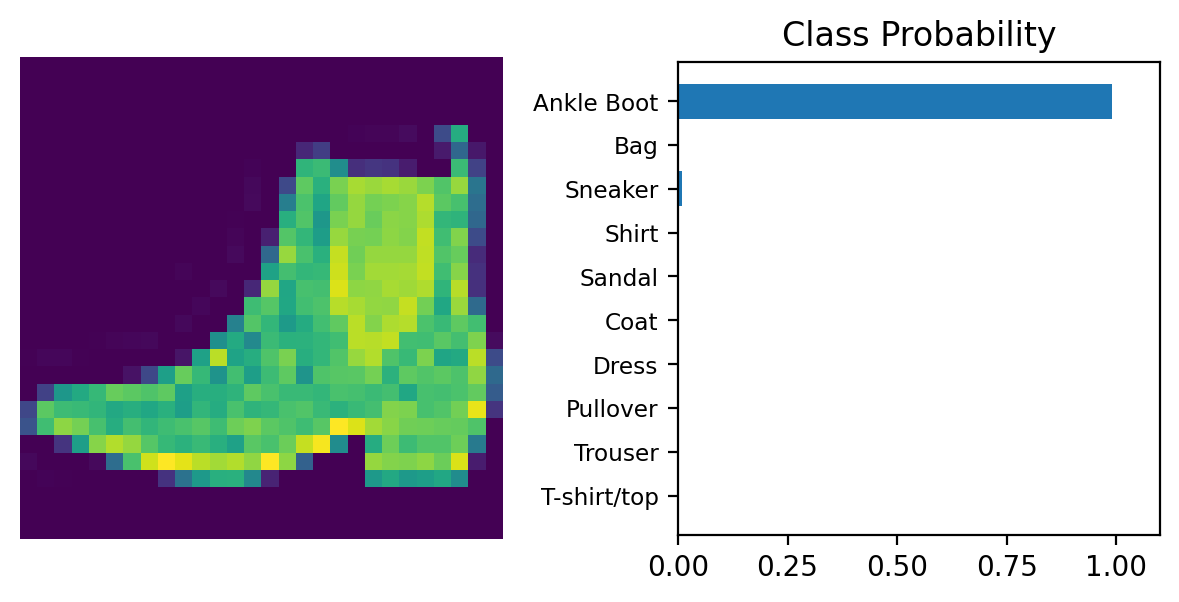

In [25]:
# Make sure 'model' and 'testloader' are defined and loaded from previous cells.

# --- Existing code from your snippet ---
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import torch # Ensure torch is imported
from torch import nn, optim
# from torch.autograd import Variable # Variable is deprecated, not needed for this

# --- Assuming testloader is defined ---
dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[1] # img is likely [1, 28, 28] (one channel, 28x28 pixels)

# --- Locally defined view_classify function (as in your snippet) ---
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    # Use .view() instead of .resize_() for safety if img is used elsewhere
    ax1.imshow(img.view(1, 28, 28).numpy().squeeze()) 
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()
# --- End of view_classify function ---

# --- Corrected part for model prediction ---
# Ensure your model is in evaluation mode
if 'model' in locals() and isinstance(model, nn.Module): # Check if model exists
    model.eval()

    # Prepare the image for the model (flatten it)
    # img is [1, 28, 28], model likely expects [batch_size, features] i.e. [1, 784]
    img_for_model = img.view(1, -1) 

    # Calculate the class probabilities (softmax) for img
    with torch.no_grad(): # Turn off gradients for inference
        logps = model(img_for_model)

    ps = torch.exp(logps)

    # Plot the image and probabilities
    # Pass the original 'img' ([1, 28, 28]) to view_classify for display
    view_classify(img, ps, version='Fashion')
    plt.show() # Explicitly show plot, though %matplotlib inline should handle it
else:
    print("Model not defined. Please define and train your model in a previous cell.")
